原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [2]:
import keras
keras.__version__

'2.2.4'

# Visualizing what convnets learn
# 卷积神经网络的可视化

This notebook contains the code sample found in Chapter 5, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

It is often said that deep learning models are "black boxes", learning representations that are difficult to extract and present in a 
human-readable form. While this is partially true for certain types of deep learning models, it is definitely not true for convnets. The 
representations learned by convnets are highly amenable to visualization, in large part because they are _representations of visual 
concepts_. Since 2013, a wide array of techniques have been developed for visualizing and interpreting these representations. We won't 
survey all of them, but we will cover three of the most accessible and useful ones:

* Visualizing intermediate convnet outputs ("intermediate activations"). This is useful to understand how successive convnet layers 
transform their input, and to get a first idea of the meaning of individual convnet filters.
* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive 
to.
* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging 
to a given class, and thus allows to localize objects in images.

For the first method -- activation visualization -- we will use the small convnet that we trained from scratch on the cat vs. dog 
classification problem two sections ago. For the next two methods, we will use the VGG16 model that we introduced in the previous section.


人们常说，深度学习模型是“黑盒”，即模型学到的表示很难用人类可以理解的方式来提取和呈现。虽然对于某些类型的深度学习模型来说，这种说法部分正确，但对卷积神经网络来说绝对不是这样。卷积神经网络学到的表示非常适合可视化，很大程度上是因为它们是视觉概念的表示。自 2013 年以来，人们开发了多种技术来对这些表示进行可视化和解释。我们不会在书中全部介绍，但会介绍三种最容易理解也最有用的方法。

* 可视化卷积神经网络的中间输出（中间激活）：有助于理解卷积神经网络连续的层如何对输入进行变换，也有助于初步了解卷积神经网络每个过滤器的含义。
* 可视化卷积神经网络的过滤器：有助于精确理解卷积神经网络中每个过滤器容易接受的视觉模式或视觉概念。
* 可视化图像中类激活的热力图：有助于理解图像的哪个部分被识别为属于某个类别，从而可以定位图像中的物体。

对于第一种方法（即激活的可视化），我们将使用 5.2 节在猫狗分类问题上从头开始训练的小型卷积神经网络。对于另外两种可视化方法，我们将使用 5.3 节介绍的 VGG16 模型。


## Visualizing intermediate activations

Visualizing intermediate activations consists in displaying the feature maps that are output by various convolution and pooling layers in a 
network, given a certain input (the output of a layer is often called its "activation", the output of the activation function). This gives 
a view into how an input is decomposed unto the different filters learned by the network. These feature maps we want to visualize have 3 
dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these 
feature maps is by independently plotting the contents of every channel, as a 2D image.
Let's start by loading the model that we saved in section 5.2:

## 可视化中间激活

可视化中间激活，是指对于给定输入，展示网络中各个卷积层和池化层输出的特征图（层的输出通常被称为该层的激活，即激活函数的输出）。这让我们可以看到输入如何被分解为网络 学到的不同过滤器。我们希望在三个维度对特征图进行可视化：宽度、高度和深度（通道）。每个通道都对应相对独立的特征，所以将这些特征图可视化的正确方法是将每个通道的内容分别绘制成二维图像。我们首先来加载 5.2 节保存的模型。


In [6]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.（ 作为提醒）

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

This will be the input image we will use -- a picture of a cat, not part of images that the network was trained on:

接下来，我们需要一张输入图像，即一张猫的图像，它不属于网络的训练图像。

In [7]:
img_path = 'data/cats_and_dogs_small/test/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor（将图像预处理为一个 4D 张量）
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
# 请记住，训练模型的输入数据都用这种方法预处理

img_tensor /= 255.

# Its shape is (1, 150, 150, 3)（# 其形状为 (1, 150, 150, 3)）
print(img_tensor.shape)

(1, 150, 150, 3)


Let's display our picture:

我们来显示这张图像：

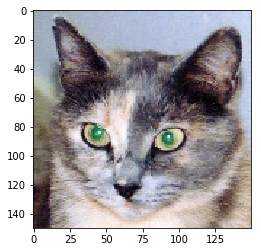

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs 
the activations of all convolution and pooling layers. To do this, we will use the Keras class `Model`. A `Model` is instantiated using two 
arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras 
model, just like the `Sequential` models that you are familiar with, mapping the specified inputs to the specified outputs. What sets the 
`Model` class apart is that it allows for models with multiple outputs, unlike `Sequential`. For more information about the `Model` class, see 
Chapter 7, Section 1.

为了提取想要查看的特征图，我们需要创建一个 Keras 模型，以图像批量作为输入，并输出 所有卷积层和池化层的激活。为此，我们需要使用 Keras 的 Model 类。模型实例化需要两个参数：一个输入张量（或输入张量的列表）和一个输出张量（或输出张量的列表）。得到的类是一个 Keras 模型，就像你熟悉的 Sequential 模型一样，将特定输入映射为特定输出。Model 类允许模型有多个输出，这一点与 Sequential 模型不同。想了解 Model 类的更多信息，请参见 7.1 节。

In [9]:
from keras import models

# Extracts the outputs of the top 8 layers:（提取前 8 层的输出）
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:（创建一个模型，给定模型输入， 可以返回这些输出）
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is the first time you encounter 
a multi-output model in this book: until now the models you have seen only had exactly one input and one output. In the general case, a 
model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

输入一张图像，这个模型将返回原始模型前 8 层的激活值。这是你在本书中第一次遇到的多输出模型，之前的模型都是只有一个输入和一个输出。一般情况下，模型可以有任意个输入和输出。这个模型有一个输入和 8 个输出，即每层激活对应一个输出。


In [10]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
# 返回 8 个 Numpy 数组组成的列表， 每个层激活对应一个 Numpy 数组
activations = activation_model.predict(img_tensor)

For instance, this is the activation of the first convolution layer for our cat image input:

例如，这是我们猫图像输入的第一个卷积层的激活：

In [11]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


It's a 148x148 feature map with 32 channels. Let's try visualizing the 3rd channel:

它是大小为 148×148 的特征图，有 32 个通道。我们来绘制原始模型第一层激活的第 3 个通道

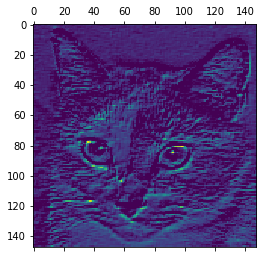

In [12]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

This channel appears to encode a diagonal edge detector. Let's try the 30th channel -- but note that your own channels may vary, since the 
specific filters learned by convolution layers are not deterministic.

这个通道似乎是对角边缘检测器。我们再看一下第 30 个通道（见下图）。但请注意，你的通道可能与此不同，因为卷积层学到的过滤器并不是确定的。

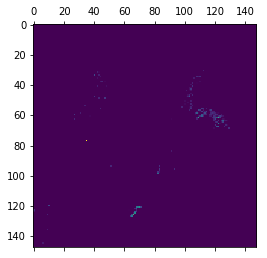

In [13]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

This one looks like a "bright green dot" detector, useful to encode cat eyes. At this point, let's go and plot a complete visualization of 
all the activations in the network. We'll extract and plot every channel in each of our 8 activation maps, and we will stack the results in 
one big image tensor, with channels stacked side by side.

这个通道看起来像是“鲜绿色圆点”检测器，对寻找猫眼睛很有用。下面我们来绘制网络中所有激活的完整可视化（见上图）。我们需要在 8 个特征图中的每一个中提取并绘制每一个通道，然后将结果叠加在一个大的图像张量中，按通道并排。

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: RuntimeWarning: invalid value encountered in true_divide


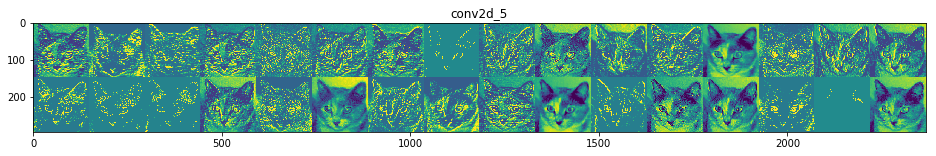

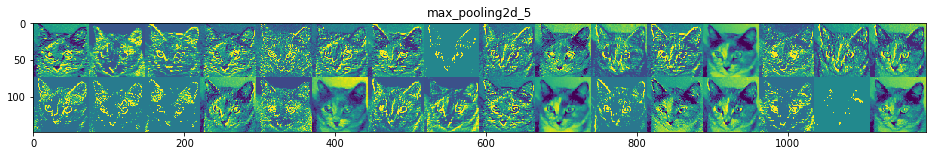

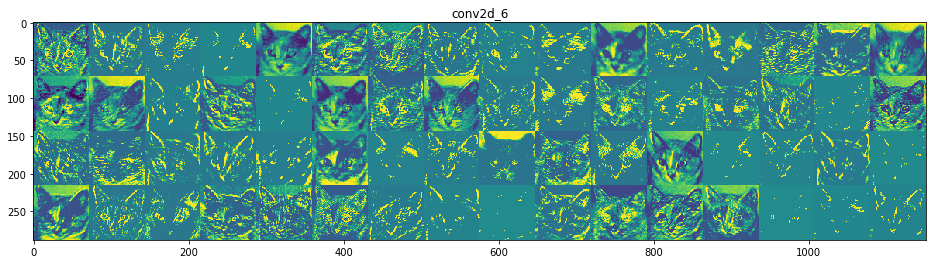

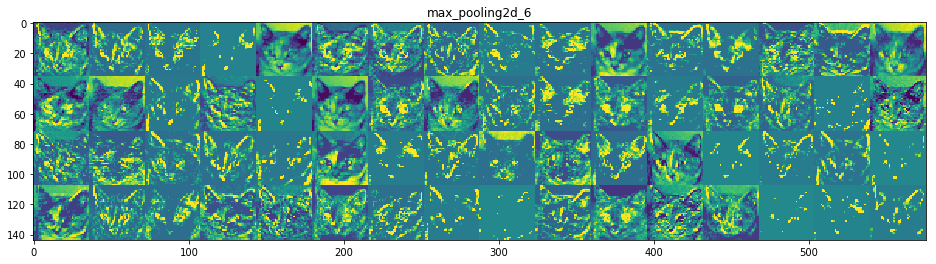

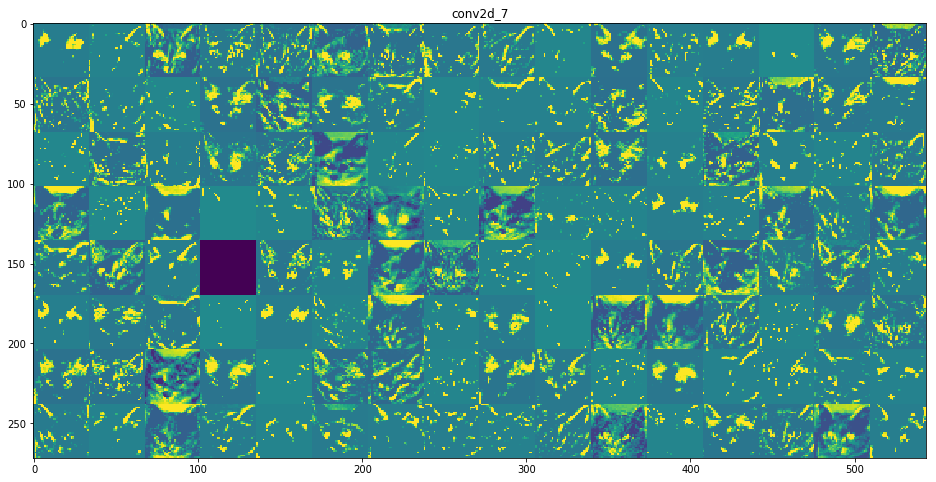

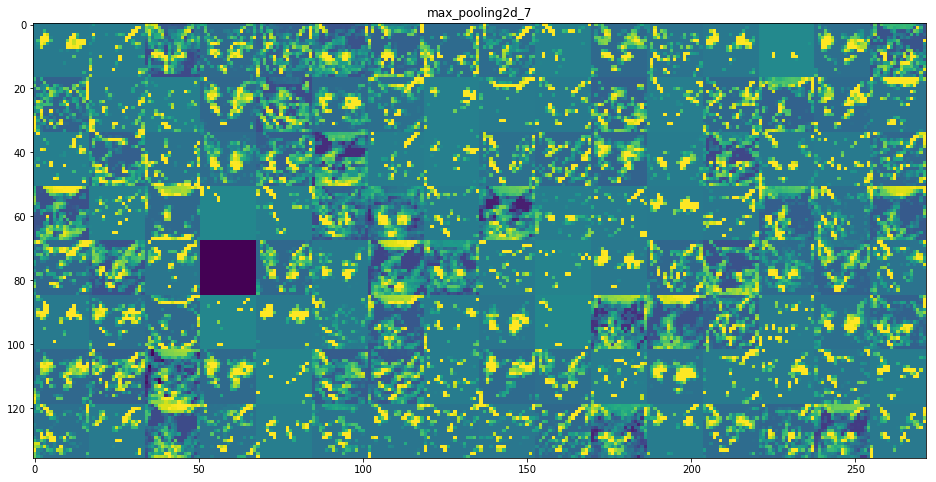

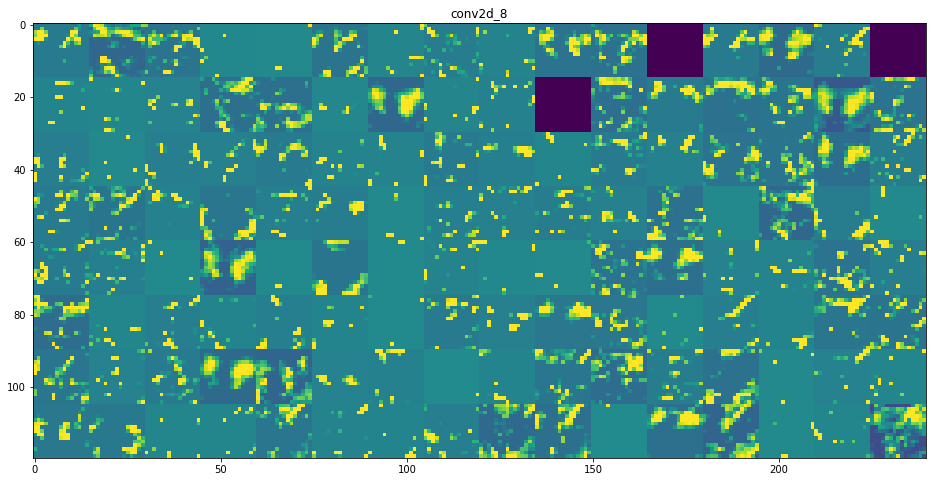

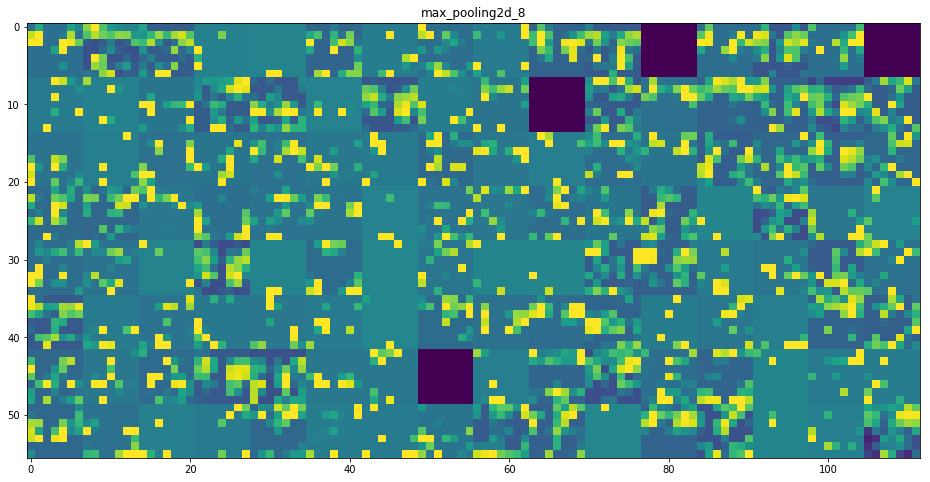

In [14]:
import keras

# These are the names of the layers, so can have them as part of our plot
# 层的名称，这样你可以将这些名称画到图中
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps（显示特征图）
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map（特征图中的特征个数）
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
#     特征图的形状为 (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
#     在这个矩阵中将激活通道平铺
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
#     将每个过滤器平铺到一个大的水平网格中
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            # 对特征进行后 处理，使其看 起来更美观
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid（显示网格）
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

A few remarkable things to note here:

* The first layer acts as a collection of various edge detectors. At that stage, the activations are still retaining almost all of the 
information present in the initial picture.
* As we go higher-up, the activations become increasingly abstract and less visually interpretable. They start encoding higher-level 
concepts such as "cat ear" or "cat eye". Higher-up presentations carry increasingly less information about the visual contents of the 
image, and increasingly more information related to the class of the image.
* The sparsity of the activations is increasing with the depth of the layer: in the first layer, all filters are activated by the input 
image, but in the following layers more and more filters are blank. This means that the pattern encoded by the filter isn't found in the 
input image.

这里需要注意以下几点。
* 第一层是各种边缘探测器的集合。在这一阶段，激活几乎保留了原始图像中的所有信息。
* 随着层数的加深，激活变得越来越抽象，并且越来越难以直观地理解。它们开始表示更高层次的概念，比如“猫耳朵”和“猫眼睛”。层数越深，其表示中关于图像视觉内容的信息就越少，而关于类别的信息就越多。
* 激活的稀疏度（sparsity）随着层数的加深而增大。在第一层里，所有过滤器都被输入图像激活，但在后面的层里，越来越多的过滤器是空白的。也就是说，输入图像中找不到这些过滤器所编码的模式。



We have just evidenced a very important universal characteristic of the representations learned by deep neural networks: the features 
extracted by a layer get increasingly abstract with the depth of the layer. The activations of layers higher-up carry less and less 
information about the specific input being seen, and more and more information about the target (in our case, the class of the image: cat 
or dog). A deep neural network effectively acts as an __information distillation pipeline__, with raw data going in (in our case, RBG 
pictures), and getting repeatedly transformed so that irrelevant information gets filtered out (e.g. the specific visual appearance of the 
image) while useful information get magnified and refined (e.g. the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which 
abstract objects were present in it (e.g. bicycle, tree) but could not remember the specific appearance of these objects. In fact, if you 
tried to draw a generic bicycle from mind right now, chances are you could not get it even remotely right, even though you have seen 
thousands of bicycles in your lifetime. Try it right now: this effect is absolutely real. You brain has learned to completely abstract its 
visual input, to transform it into high-level visual concepts while completely filtering out irrelevant visual details, making it 
tremendously difficult to remember how things around us actually look.

我们刚刚揭示了深度神经网络学到的表示的一个重要普遍特征：随着层数的加深，层所提取的特征变得越来越抽象。更高的层激活包含关于特定输入的信息越来越少，而关于目标的信息越来越多（本例中即图像的类别：猫或狗）。深度神经网络可以有效地作为信息蒸馏管道（information distillation pipeline），输入原始数据（本例中是 RGB 图像），反复对其进行变换， 将无关信息过滤掉（比如图像的具体外观），并放大和细化有用的信息（比如图像的类别）。

这与人类和动物感知世界的方式类似：人类观察一个场景几秒钟后，可以记住其中有哪些 抽象物体（比如自行车、树），但记不住这些物体的具体外观。事实上，如果你试着凭记忆画一辆普通自行车，那么很可能完全画不出真实的样子，虽然你一生中见过上千辆自行车（见 图 5-28）。你可以现在就试着画一下，这个说法绝对是真实的。你的大脑已经学会将视觉输入完全抽象化，即将其转换为更高层次的视觉概念，同时过滤掉不相关的视觉细节，这使得大脑很难记住周围事物的外观。


## Visualizing convnet filters


Another easy thing to do to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond 
to. This can be done with __gradient ascent in input space__: applying __gradient descent__ to the value of the input image of a convnet so 
as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen 
filter is maximally responsive to.

The process is simple: we will build a loss function that maximizes the value of a given filter in a given convolution layer, then we 
will use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. For instance, here's 
a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

## 可视化卷积神经网络的过滤器

想要观察卷积神经网络学到的过滤器，另一种简单的方法是显示每个过滤器所响应的视觉模式。这可以通过在输入空间中进行梯度上升来实现：从空白输入图像开始，将梯度下降应用于卷积神经网络输入图像的值，其目的是让某个过滤器的响应最大化。得到的输入图像是选定 过滤器具有最大响应的图像。

这个过程很简单：我们需要构建一个损失函数，其目的是让某个卷积层的某个过滤器的值最大化；然后，我们要使用随机梯度下降来调节输入图像的值，以便让这个激活值最大化。例如， 对于在ImageNet 上预训练的 VGG16 网络，其 block3_conv1层第 0 个过滤器激活的损失如下所示：



In [15]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement gradient descent, we will need the gradient of this loss with respect to the model's input. To do this, we will use the 
`gradients` function packaged with the `backend` module of Keras:

为了实现梯度下降，我们需要得到损失相对于模型输入的梯度。为此，我们需要使用 Keras的 backend 模块内置的 gradients 函数。


In [16]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
# 调用 gradients 返回的是一个张量列表（本例中列表长度为 1）。因此，只保留第一个元素，它是一个张量

grads = K.gradients(loss, model.input)[0]

A non-obvious trick to use for the gradient descent process to go smoothly is to normalize the gradient tensor, by dividing it by its L2 
norm (the square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the 
input image is always within a same range.

为了让梯度下降过程顺利进行，一个非显而易见的技巧是将梯度张量除以其 L2 范数（张量 中所有值的平方的平均值的平方根）来标准化。这就确保了输入图像的更新大小始终位于相同的范围。

In [17]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Now we need a way to compute the value of the loss tensor and the gradient tensor, given an input image. We can define a Keras backend 
function to do this: `iterate` is a function that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy 
tensors: the loss value and the gradient value.

现在你需要一种方法：给定输入图像，它能够计算损失张量和梯度张量的值。你可以定义一个 Keras 后端函数来实现此方法：iterate 是一个函数，它将一个 Numpy 张量（表示为长度 为 1 的张量列表）转换为两个 Numpy 张量组成的列表，这两个张量分别是损失值和梯度值。


In [18]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:（测试下）
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

At this point we can define a Python loop to do stochastic gradient descent:

现在你可以定义一个 Python 循环来进行随机梯度下降。

In [19]:
# We start from a gray image with some noise（从一张带有噪声的 灰度图像开始）
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps（运行 40 次梯度上升）
step = 1.  # this is the magnitude of each gradient update（每次梯度更新的步长）
for i in range(40):
    # Compute the loss value and gradient value（计算损失值和梯度值）
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
#  沿着让损失最大化的 方向调节输入图像   
    input_img_data += grads_value * step

The resulting image tensor will be a floating point tensor of shape `(1, 150, 150, 3)`, with values that may not be integer within `[0, 
255]`. Hence we would need to post-process this tensor to turn it into a displayable image. We do it with the following straightforward 
utility function:

得到的图像张量是形状为 (1, 150, 150, 3) 的浮点数张量，其取值可能不是 [0, 255] 区间内的整数。因此，你需要对这个张量进行后处理，将其转换为可显示的图像。下面这个简单的实用函数可以做到这一点。


In [20]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
#     对张量做标准化，使其均值为 0， 标准差为 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]（将 x 裁切（clip）到 [0, 1] 区间）
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array（将 x 转换为 RGB 数组）
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now we have all the pieces, let's put them together into a Python function that takes as input a layer name and a filter index, and that 
returns a valid image tensor representing the pattern that maximizes the activation the specified filter:

接下来，我们将上述代码片段放到一个 Python 函数中，输入一个层的名称和一个过滤器索引，它将返回一个有效的图像张量，表示能够将特定过滤器的激活最大化的模式。


In [21]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
#     构建一个损失函数，将该层第 n 个过滤器的激活最大化
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
#     计算这个损失相对于输入图像的梯度
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
#     标准化技巧：将梯度标准化
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
#     返回给定输入图像的损失和梯度
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise（从带有噪声的灰度图像开始）
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps（运行 40 次梯度上升）
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

Let's try this:

我们来试用一下这个函数：

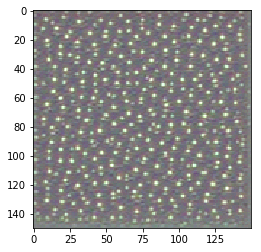

In [22]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

It seems that filter 0 in layer `block3_conv1` is responsive to a polka dot pattern.

Now the fun part: we can start visualising every single filter in every layer. For simplicity, we will only look at the first 64 filters in 
each layer, and will only look at the first layer of each convolution block (block1_conv1, block2_conv1, block3_conv1, block4_conv1, 
block5_conv1). We will arrange the outputs on a 8x8 grid of 64x64 filter patterns, with some black margins between each filter pattern.

看起来，block3_conv1 层第 0 个过滤器响应的是波尔卡点（polka-dot）图案。

下面来看有趣的部分：我们可以将每一层的每个过滤器都可视化。为了简单起见，我们只查看每一层的前 64 个过滤器，并只查看每个卷积块的第一层（即 block1_conv1、block2_conv1、block3_conv1、block4_ conv1、block5_conv1）。我们将输出放在一个 8×8 的网格中， 每个网格是一个 64 像 素×64  像素的过滤器模式，两个过滤器模式之间留有一些黑边（见上图）。


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


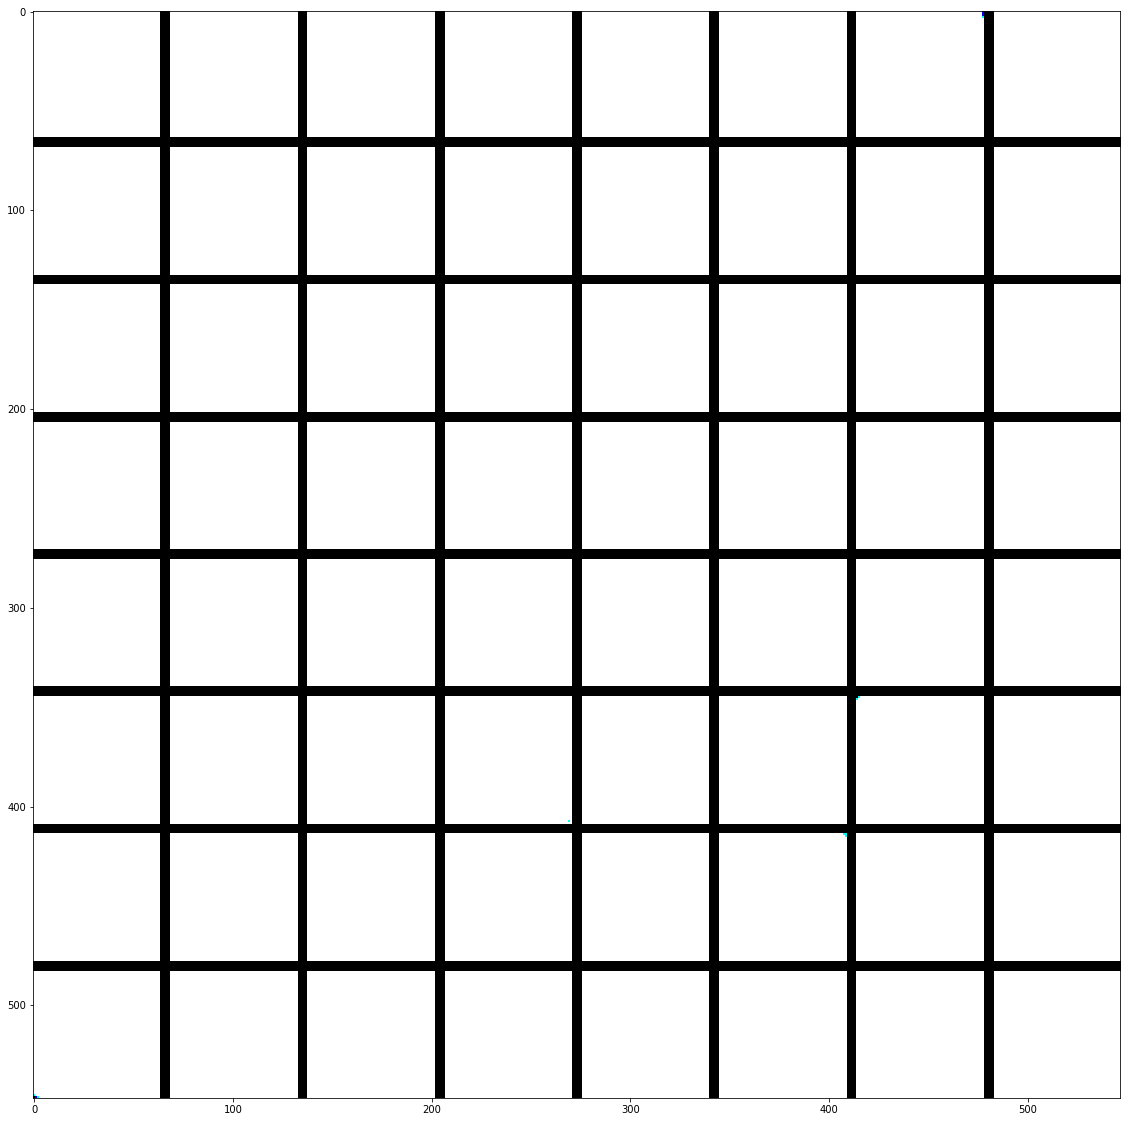

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


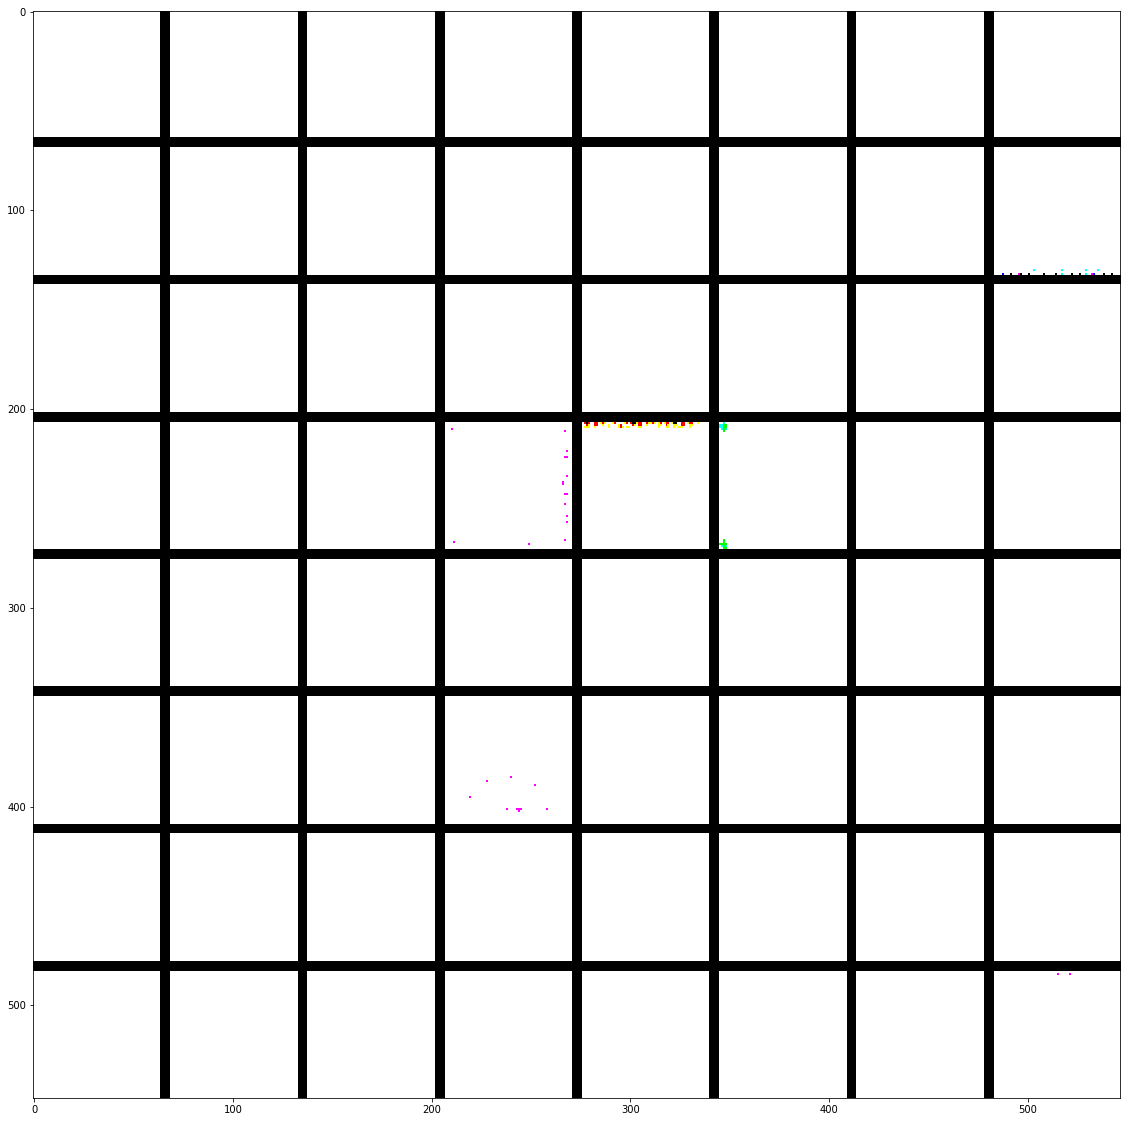

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


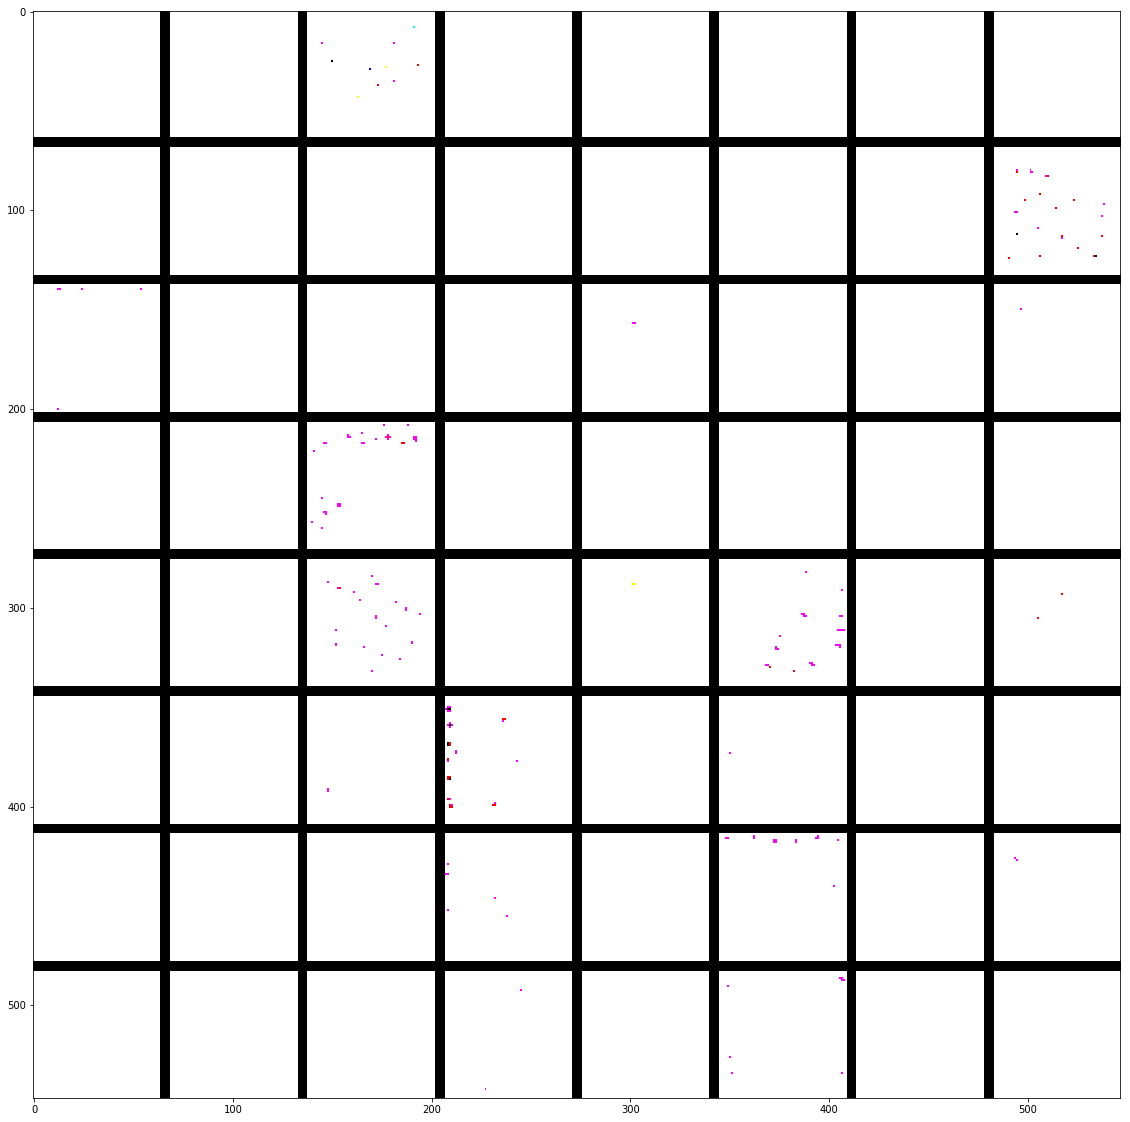

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


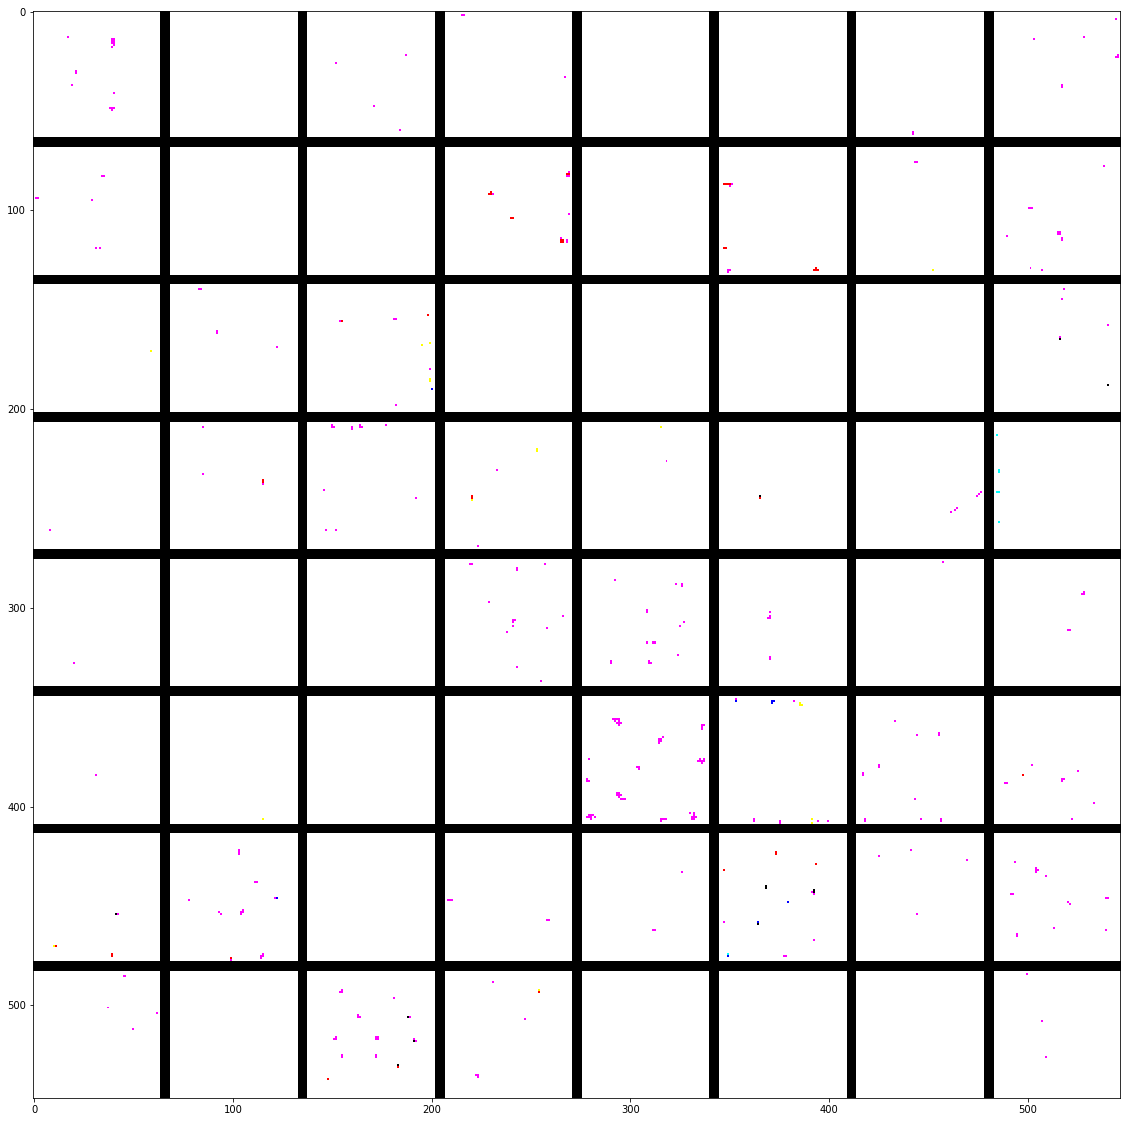

In [23]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
#     空图像（全黑色）， 用于保存结果
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid（遍历 results 网格的行）
        for j in range(8):  # iterate over the columns of our results grid（遍历 results 网格的列）
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
#             生成 layer_name 层第 i +（j * 8）个过滤器的模式
 
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            #  将结果放到 results 网格第 (i, j) 个方块中

            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid（显示 results 网格）
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

These filter visualizations tell us a lot about how convnet layers see the world: each layer in a convnet simply learns a collection of 
filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes 
signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as we go higher-up 
in the model:

* The filters from the first layer in the model (`block1_conv1`) encode simple directional edges and colors (or colored edges in some 
cases).
* The filters from `block2_conv1` encode simple textures made from combinations of edges and colors.
* The filters in higher-up layers start resembling textures found in natural images: feathers, eyes, leaves, etc.

这些过滤器可视化包含卷积神经网络的层如何观察世界的很多信息：卷积神经网络中每一层都学习一组过滤器，以便将其输入表示为过滤器的组合。这类似于傅里叶变换将信号分解为一 组余弦函数的过程。随着层数的加深，卷积神经网络中的过滤器变得越来越复杂，越来越精细。
* 模型第一层（block1_conv1）的过滤器对应简单的方向边缘和颜色（还有一些是彩色边缘）。
* block2_conv1 层的过滤器对应边缘和颜色组合而成的简单纹理。
* 更高层的过滤器类似于自然图像中的纹理：羽毛、眼睛、树叶等。


## Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its 
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification 
mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".

We will demonstrate this technique using the pre-trained VGG16 network again:

## 可视化类激活的热力图

我还要介绍另一种可视化方法，它有助于了解一张图像的哪一部分让卷积神经网络做出了最终的分类决策。这有助于对卷积神经网络的决策过程进行调试，特别是出现分类错误的情况下。 这种方法还可以定位图像中的特定目标。

这种通用的技术叫作类激活图（CAM，class activation map）可视化，它是指对输入图像生成类激活的热力图。类激活热力图是与特定输出类别相关的二维分数网格，对任何输入图像的每个位置都要进行计算，它表示每个位置对该类别的重要程度。举例来说，对于输入到猫狗分 类卷积神经网络的一张图像，CAM可视化可以生成类别“猫”的热力图，表示图像的各个部分与“猫”的相似程度，CAM 可视化也会生成类别“狗”的热力图，表示图像的各个部分与“狗”的相似程度。

我们将使用的具体实现方式是“Grad-CAM: visual explanations from deep networks via gradient- based localization”a  这篇论文中描述的方法。这种方法非常简单：给定一张输入图像，对于一个卷积层的输出特征图，用类别相对于通道的梯度对这个特征图中的每个通道进行加权。直观上来看，理解这个技巧的一种方法是，你是用“每个通道对类别的重要程度”对“输入图像对不同通道的激活强度”的空间图进行加权，从而得到了“输入图像对类别的激活强度”的空间图。

我们再次使用预训练的 VGG16 网络来演示此方法。


In [24]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
# 注意，网络中包括了密集连接分类器。在前面所有的例子中，我们都舍弃了这个分类器
model = VGG16(weights='imagenet')

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 64373286793e3c8b2b4e3219cbf3544b so we will re-download the data.
553467904/553467096 [==============================] - 3836s 7us/step


Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna (under a Creative 
Commons license):

下图显示了两只非洲象的图像（遵守知识共享许可协议），可能是一只母象和它的小象，它们在大草原上漫步。

![elephants](data/creative_commons_elephant.jpg)

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according 
to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize 
it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

我们将这张图像转换为 VGG16 模型能够读取的格式：模型在大小为224×224 的图像上进行训练，这些训练图像都根据 keras.applications.vgg16.preprocess_ input 函数中内置的规则进行预处理。因此，我们需要加载图像，将其大小调整为 224×224， 然后将其转换为 float32 格式的 Numpy 张量，并应用这些预处理规则。


In [25]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image（目标图像的 本地路径）
img_path = 'data/creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
# （大小为 224×224 的Python图像库（PIL，Python imaging library）图像）
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
# x形 状 为 (224, 224, 3) 的float32 格式的 Numpy 数组

x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
# 添加一个维 度，将数组转换为 (1, 224, 224, 3) 形状的批量

x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
# 对批量进行预处理（按通道进行颜色标准化）
x = preprocess_input(x)

In [26]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.9094216), ('n01871265', 'tusker', 0.086182274), ('n02504013', 'Indian_elephant', 0.0043545854)]



The top-3 classes predicted for this image are:

* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector 
that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

对这张图像预测的前三个类别分别为：
* 非洲象（African elephant，92.5% 的概率）
* 长牙动物（tusker，7% 的概率）
* 印度象（Indian elephant，0.4% 的概率） 网络识别出图像中包含数量不确定的非洲象。

预测向量中被最大激活的元素是对应“非洲象”类别的元素，索引编号为 386。


In [27]:
np.argmax(preds[0])

386

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

为了展示图像中哪些部分最像非洲象，我们来使用 Grad-CAM 算法。

In [28]:
# This is the "african elephant" entry in the prediction vector
# 预测向量中的“非洲象”元素
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
# block5_conv3 层的输出特征图，它是VGG16的最后一个卷积层
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
# “非洲象”类别相对于 block5_conv3输出特征图的梯度

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel

# 形状为 (512,) 的向量，每个元素是特定特征图通道的梯度平均大小
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image

# 访问刚刚定义的量：对于给定的样本图像，pooled_grads 和 block5_conv3 层的输出特征图

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
# 对于两个大象的样本图像， 这两个量都是 Numpy 数组
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
# 将特征图数组的每个 通道乘以“这个通道 对‘大象’类别的重要程度”
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
# 得到的特征图的逐通道平均值即为类激活的热力图

heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

为了便于可视化，我们还需要将热力图标准化到 0~1 范围内。

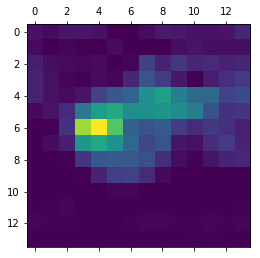

In [29]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

最后，我们可以用 OpenCV 来生成一张图像，将原始图像叠加在刚刚得到的热力图上

In [30]:
import cv2

# We use cv2 to load the original image（用 cv2 加载原始图像）
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
# 将热力图的大小调整 为与原始图像相同
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB（将热力图转换为 RGB 格式）
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image（将热力图应用于原始图像）
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor（这里的 0.4 是热力图强度因子）
superimposed_img = heatmap * 0.4 + img

# Save the image to disk（将图像保存到硬盘）
cv2.imwrite('data/elephant_cam.jpg', superimposed_img)

True


![elephant cam](data/elephant_cam.jpg)

This visualisation technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can 
tell the difference between African and Indian elephants.

这种可视化方法回答了两个重要问题：
* 网络为什么会认为这张图像中包含一头非洲象？
* 非洲象在图像中的什么位置？ 尤其值得注意的是，小象耳朵的激活强度很大，这可能是网络找到的非洲象和印度象的不同之处。
